# Foundations of Transformers in Neuroscience Tutorial

Authors: Shivashriganesh Mahato, Vinam Arora | Contributions: Mehdi Azabou, Sergey Shuvaev, Julie Young, Eva Dyer

***

The goal of this notebook is to show you how to work with datasets and dataloaders, build and train several neural decoding models (a simple MLP, a Transformer, and POYO), fine-tune a pretrained POYO model on a new session, and visualize training. This notebook is designed to be interactive and provide visual feedback. As you work through the cells, try to run them and observe the results. Detailed explanations are provided along the way.

<center>
<img src="https://torch-brain.readthedocs.io/en/latest/_static/torch_brain_logo.png" width="150" height="150" alt="torch_brain Logo">
</center>


We will focus on three main topics in this notebook:
* **Part 1: DataLoaders**
* **Part 2: Training Models**
* **Part 3: Finetuning and Visualizations**


\\
General references:

- [**torch_brain** documentation](<https://torch-brain.readthedocs.io/en/latest/index.html>)
- [pytorch tutorials](<https://pytorch.org/tutorials/beginner/basics/intro.html>)

***
## Setup

First, let's install **torch_brain**, and get you set up with some simple utility functions that will be used throughout this notebook.

In [ ]:
! uv pip install pytorch_brain -q

# We use uv for the installation here, which seems to work better with google colab.
# Although UV is awesome and we highly recommend it, you could install it with vanilla pip
# in your local environments

### Run the block below to load utility functions.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import warnings
import logging
from torch_brain.utils import seed_everything

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)


def move_to_gpu(data, device):
    """
    Recursively moves tensors (or collections of tensors) to the given device.
    """
    if isinstance(data, torch.Tensor):
        return data.to(device)
    elif isinstance(data, dict):
        return {k: move_to_gpu(v, device) for k, v in data.items()}
    elif isinstance(data, list):
        return [move_to_gpu(elem, device) for elem in data]
    else:
        return data


def bin_spikes(spikes, num_units, bin_size, right=True, num_bins=None):
    """
    Bins spike timestamps into a 2D array: [num_units x num_bins].
    """
    rate = 1 / bin_size  # avoid precision issues
    binned_spikes = np.zeros((num_units, num_bins))
    bin_index = np.floor((spikes.timestamps) * rate).astype(int)
    np.add.at(binned_spikes, (spikes.unit_index, bin_index), 1)
    return binned_spikes


def r2_score(y_pred, y_true):
    # Compute total sum of squares (variance of the true values)
    y_true_mean = torch.mean(y_true, dim=0, keepdim=True)
    ss_total = torch.sum((y_true - y_true_mean) ** 2)

    # Compute residual sum of squares
    ss_res = torch.sum((y_true - y_pred) ** 2)

    # Compute R^2
    r2 = 1 - ss_res / ss_total

    return r2


def compute_r2(dataloader, model):
    # Compute R2 score over the entire dataset
    total_target = []
    total_pred = []
    for batch in dataloader:
        batch = move_to_gpu(batch, device)
        pred = model(**batch["model_inputs"])
        target = batch["target_values"]

        # Store target and pred for visualization
        mask = torch.ones_like(target, dtype=torch.bool)
        if "output_mask" in batch["model_inputs"]:
            mask = batch["model_inputs"]["output_mask"]
        total_target.append(target[mask])
        total_pred.append(pred[mask])

    # Concatenate all batch outputs
    total_target = torch.cat(total_target)
    total_pred = torch.cat(total_pred)

    # Compute the R2 score
    r2 = r2_score(total_pred.flatten(), total_target.flatten())

    return r2.item(), total_target, total_pred


def print_model(model: torch.nn.Module):
    """
    Prints a summary of the model architecture and parameter count.
    """
    model_str = str(model).split('\n')
    print("\nModel:")
    print('\n'.join(model_str[:5]))
    print("...")
    print('\n'.join(model_str[-min(5, len(model_str)):]))
    num_params = sum(p.numel() for p in model.parameters())
    if num_params > 1e9:
        param_str = f"{num_params/1e9:.1f}G"
    elif num_params > 1e6:
        param_str = f"{num_params/1e6:.1f}M"
    else:
        param_str = f"{num_params/1e3:.1f}K"
    print(f"\nNumber of parameters: {param_str}\n")


def plot_training_curves(r2_log, loss_log):
    """
    Plots the training curves: training loss and validation R2 score.
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(0, len(loss_log), len(loss_log)), loss_log)
    plt.title("Training Loss")
    plt.xlabel("Training Steps")
    plt.ylabel("MSE Loss")
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(r2_log)
    plt.title("Validation R2")
    plt.xlabel("Epochs")
    plt.ylabel("R2 Score")
    plt.grid()
    plt.tight_layout()
    plt.show()


def generate_sinusoidal_position_embs(num_timesteps, dim):
    position = torch.arange(num_timesteps).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2) * (-np.log(10000.0) / dim))
    pe = torch.empty(num_timesteps, dim)
    pe[:, 0:dim // 2] = torch.sin(position * div_term)
    pe[:, dim//2:] = torch.cos(position * div_term)
    return pe


def load_pretrained(ckpt_path, model):
    print("Loading pretrained model...")
    checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)
    # poyo is pretrained using lightning, so model weights are prefixed with "model."
    state_dict = {k.replace("model.", ""): v for k, v in checkpoint["state_dict"].items()}
    model.load_state_dict(state_dict)
    print("Done!")
    return model


def reinit_vocab(emb_module, vocab):
    emb_module.extend_vocab(vocab)
    emb_module.subset_vocab(vocab)


def get_dataset_config(brainset, sessions):
    brainset_norms = {
        "perich_miller_population_2018": {
            "mean": 0.0,
            "std": 20.0
        }
    }

    config = f"""
    - selection:
      - brainset: {brainset}
        sessions:"""
    if type(sessions) is not list:
        sessions = [sessions]
    for session in sessions:
        config += f"""
          - {session}"""
    config += f"""
      config:
        readout:
          readout_id: cursor_velocity_2d
          normalize_mean: {brainset_norms[brainset]["mean"]}
          normalize_std: {brainset_norms[brainset]["std"]}
          metrics:
            - metric:
                _target_: torchmetrics.R2Score
    """

    config = OmegaConf.create(config)

    return config

***

## Part 1: Data Loading

***

### Table of contents:
* 1.1 The life of a data sample
* 1.2 Setting up a basic data pipeline
* 1.3 Downloading a session

### 1.1 The life of a data sample

In the previous notebook, we saw how **torch_brain.data.Dataset** efficiently produces a data sample. But once a sample is drawn—what happens next?

1.	A data sample originates from the dataset. In **torch_brain**, this typically refers to a short time-slice of a neural recording.
2. Optionally, the sample can be transformed—for example, by applying augmentations such as dropping out neurons or brain regions.
3. Next, the sample is further processed and reshaped into a format suitable for model input. We refer to this step as **tokenization**.
4. The tokenized sample is then **collated** with other samples to form a **batch**.
5.	Finally, the batch is passed through the model for the forward computation and loss evaluation.

This process can be seen visually through the diagram below:

<center>
<img src="https://ik.imagekit.io/7tkfmw7hc/dataloader.png?updatedAt=1743052497906" height=420 />
</center>

That’s a lot of work—and in plain PyTorch, you’d be doing it all by hand. **torch_brain** makes each of these steps easy and intuitive to build and customize.

### 1.2 Setting up a basic data pipeline

Now let's define a utility function to create the training and validation datasets, samplers, and dataloaders.
This function will be used to set up the data for training and validation of our models.

Note: We'll handle tokenization in the next part of this notebook.

In [ ]:
from torch_brain.data import Dataset, collate, chain
from torch_brain.data.sampler import RandomFixedWindowSampler, SequentialFixedWindowSampler
from torch.utils.data import DataLoader

def get_train_val_loaders(recording_id=None, cfg=None, batch_size=32, seed=0):
    """Sets up train and validation Datasets, Samplers, and DataLoaders
    """

    # -- Train --
    train_dataset = Dataset(
        root="data",                # root directory where .h5 files are found
        recording_id=recording_id,  # you either specify a single recording ID
        config=cfg,                 # or a config for multi-session training / more complex configs
        split="train",
    )
    # We use a random sampler to improve generalization during training
    train_sampling_intervals = train_dataset.get_sampling_intervals()
    train_sampler = RandomFixedWindowSampler(
        sampling_intervals=train_sampling_intervals,
        window_length=1.0,          # context window of samples
        generator=torch.Generator().manual_seed(seed),
    )
    # Finally combine them in a dataloader
    train_loader = DataLoader(
        dataset=train_dataset,      # dataset
        sampler=train_sampler,      # sampler
        batch_size=batch_size,      # num of samples per batch
        collate_fn=collate,         # the collator
        num_workers=4,              # data sample processing (slicing, transforms, tokenization) happens in parallel; this sets the amount of that parallelization
        pin_memory=True,
    )

    # -- Validation --
    val_dataset = Dataset(
        root="data",
        recording_id=recording_id,
        config=cfg,
        split="valid",
    )
    # For validation we don't randomize samples for reproducibility
    val_sampling_intervals = val_dataset.get_sampling_intervals()
    val_sampler = SequentialFixedWindowSampler(
        sampling_intervals=val_sampling_intervals,
        window_length=1.0,
    )
    # Combine them in a dataloader
    val_loader = DataLoader(
        dataset=val_dataset,
        sampler=val_sampler,
        batch_size=batch_size,
        collate_fn=collate,
        num_workers=4,
        pin_memory=True,
    )

    train_dataset.disable_data_leakage_check()
    val_dataset.disable_data_leakage_check()

    return train_dataset, train_loader, val_dataset, val_loader

Aside from the tokenizer, that's all there is to the data pipeline! Most of it is handled behind-the-scenes with **torch_brain**.

### 1.3 Downloading a session
For our examples, we'll use data from a single neural recording from [1], which includes recordings of spiking activity from a monkey during a reaching task. Let's quickly download it to our environment.

In [ ]:
! mkdir -p data/perich_miller_population_2018
! gdown 1W--Sm_BcphEC2snoF4zwPdHkkYGgAaUw -O data/perich_miller_population_2018/t_20130819_center_out_reaching.h5

Downloading...
From: https://drive.google.com/uc?id=1W--Sm_BcphEC2snoF4zwPdHkkYGgAaUw
To: /content/data/perich_miller_population_2018/t_20130819_center_out_reaching.h5
100% 9.88M/9.88M [00:00<00:00, 157MB/s]


Now, let's jump into training some models!

***

## Part 2: Training Models

***

In this section, we walk through training different neural decoders. We'll structure the code so there's a common training loop, then move onto implementing:

- A simple MLP Neural Decoder
- A Transformer-based Neural Decoder [2]
- POYO! [3]

### 2.1 Warmup: Implementing an MLP based Neural Activity Decoder

To learn how to write and train models in the `torch_brain` framework, let's kick things off with a simple MLP Neural Decoder.

#### 2.1.1 Defining the Model

In **torch_brain**, every model needs to define two important methods:
1. `model.tokenize`: the tokenization step, which processes and reshapes data to align with model input.
2. `model.forward`: the forward pass, which produces predictions.

In case of an MLP decoder, these will look like:

<center>
<img src="https://ik.imagekit.io/7tkfmw7hc/mlp.png?updatedAt=1743064332486" width=900 />
</center>

In [ ]:
import torch.nn as nn

class MLPNeuralDecoder(nn.Module):
    def __init__(self, num_units, bin_size, sequence_length, output_dim, hidden_dim):
        """Initialize the neural net layers."""
        super().__init__()

        self.num_timesteps = int(sequence_length / bin_size)
        self.bin_size = bin_size

        self.net = nn.Sequential(
            nn.Linear(self.num_timesteps * num_units, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * self.num_timesteps),
        )

    def forward(self, x):
        """Produces predictions from a binned spiketrain.
        This is pure PyTorch code.

        Shape of x: (B, T, N)
        """

        x = x.flatten(1)                          # (B, T, N)    -> (B, T*N)
        x = self.net(x)                           # (B, T*N)     -> (B, T*D_out)
        x = x.reshape(-1, self.num_timesteps, 2)  # (B, T*D_out) -> (B, T, D_out)
        return x

    def tokenize(self, data):
        """tokenizes a data sample, which is a sliced Data object"""

        # A. Extract and bin neural activity (data.spikes)
        spikes = data.spikes
        x = bin_spikes(
            spikes=spikes,
            num_units=len(data.units),
            bin_size=self.bin_size,
            num_bins=self.num_timesteps
        ).T
        # Final shape of x here is (timestamps, num_neurons)

        # B. Extract the corresponding cursor velocity, which will act as targets
        #    for training the MLP.
        y = data.cursor.vel
        # Final shape of y is (timestamps x 2)
        # Note that in this example we have choosen the bin size to match the
        # sampling rate of the recorded cursor velocity.

        # Finally, we output the "tokenized" data in the form of a dictionary.
        data_dict = {
            "model_inputs": {
                "x": torch.tensor(x, dtype=torch.float32),
                # Models in torch_brain typically follow the convention that
                # fields that are input to model.forward() are stored in
                # "model_inputs". Although you are free to deviate from this,
                # we have found that this convention generally produces cleaner
                # training loops.
            },
            "target_values": torch.tensor(y, dtype=torch.float32),
        }
        return data_dict

**More on tokenization:**

Recall that a data sample emitted by the Dataset is only sliced in time, but still
contains all fields present in the dataset. In the tokenizer, we:
1. Extract the fields relevant to our machine learning problem. In this case, we only care about the spiketrain and the cursor velocity.
2. Process and reshape the extracted data in a format that is convenient for our model to process. In our example, we bin the spiketrain.

#### 2.1.2 Defining the Training Loop

The following functions perform the training steps. At each epoch, we use the data loader to sample batches of data and train the model using an optimizer. We then compute the R² score on the validation set to monitor the model's performance. This `train` function trains the model for a specified number of epochs and logs the R² score on the validation set.

In [ ]:
import torch.nn.functional as F

def train(model, optimizer, train_loader, val_loader, num_epochs=50, store_embs=False):
    # We'll store some intermediate outputs for visualization
    train_outputs = {
        'n_epochs': num_epochs,
        'unit_emb': [],
        'session_emb': [],
        'output_pred': [],
        'output_gt': [],
    }

    r2_log = []
    loss_log = []

    # Training loop
    for epoch in range(num_epochs):
        # Compute R² score on validation set
        r2, target, pred = compute_r2(val_loader, model)
        r2_log.append(r2)

        # Training steps
        for batch in train_loader:
            batch = move_to_gpu(batch, device)
            loss = training_step(batch, model, optimizer)
            loss_log.append(loss.item())

        print(f"\rEpoch {epoch+1}/{num_epochs} | Val R2 = {r2:.3f} | Loss = {loss.item():.3f}", end="")

        # Store intermediate outputs
        if store_embs:
            train_outputs['unit_emb'].append(model.unit_emb.weight[1:].detach().cpu().numpy())
            train_outputs['session_emb'].append(model.session_emb.weight[1:].detach().cpu().numpy())
        train_outputs['output_gt'].append(target.detach().cpu().numpy())
        train_outputs['output_pred'].append(pred.detach().cpu().numpy())

    # Compute final R² score
    r2, _, _ = compute_r2(val_loader, model)
    r2_log.append(r2)
    print(f"\nDone! Final validation R2 = {r2:.3f}")

    return r2_log, loss_log, train_outputs


def training_step(batch, model, optimizer):
    optimizer.zero_grad()                  # Step 0. Clear old gradients
    pred = model(**batch["model_inputs"])  # Step 1. Do forward pass
    target = batch["target_values"]
    loss = F.mse_loss(pred, target)        # Step 2. Compute loss
    loss.backward()                        # Step 3. Backward pass
    optimizer.step()                       # Step 4. Update model params
    return loss


#### 2.1.3 Let's train!

Num Units in Session: 55
Epoch 100/100 | Val R2 = 0.558 | Loss = 5.405
Done! Final validation R2 = 0.561


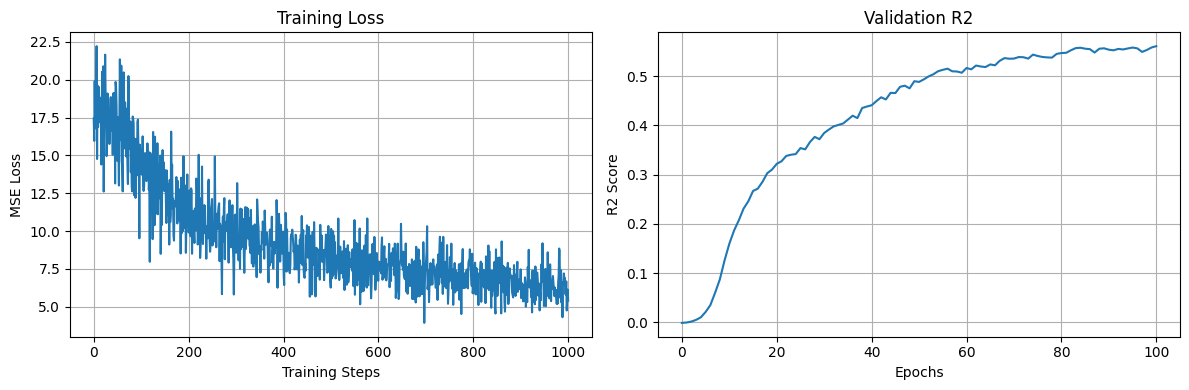

In [ ]:
seed_everything(0)

# 1. Setup datasets and dataloader
recording_id = "perich_miller_population_2018/t_20130819_center_out_reaching"
train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(recording_id, batch_size=64)
num_units = len(train_dataset.get_unit_ids())
print(f"Num Units in Session: {num_units}")

# 2. Initialize Model with the new MLP definition
mlp_model = MLPNeuralDecoder(
    num_units=num_units,    # Num. of units inputted (spiking activity)
    #
    bin_size=10e-3,         # Duration (s) of bins
    sequence_length=1.0,    # Context length of the model
    #
    output_dim=2,           # Output dimension of final readout layer
    hidden_dim=32,          # Hidden dimension of the model
)
mlp_model = mlp_model.to(device)

# 3. Connect Tokenizer to Datasets
transform = mlp_model.tokenize
train_dataset.transform = transform
val_dataset.transform = transform

# 4. Setup Optimizer
optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=1e-3)

# 5. Train!
mlp_r2_log, mlp_loss_log, mlp_train_outputs = train(mlp_model, optimizer, train_loader, val_loader, num_epochs=100)

# Plot the training loss and validation R2
plot_training_curves(mlp_r2_log, mlp_loss_log)


You should now see a training loss curve steadily decreasing and the validation R² rising. These trends mean your model is learning effectively!

### 2.2 Training a simple Transformer for Neural Decoding
Next up: let's move on to the main course - Transformers! Let's explore how attention can be used for neural decoding by building and training a simple transformer.

#### 2.2.1 Defining a Transformer model

The philosophy of having a `model.tokenize` and `model.forward` methods remains the same as before, however our model is a bit more complex than the humble MLP.

<center>
  <img src="https://ik.imagekit.io/7tkfmw7hc/transformer.png?updatedAt=1743064332335" alt="The Transformer model architecture." width=900/>
</center>


In [ ]:
from torch_brain.nn import FeedForward

class TransformerNeuralDecoder(nn.Module):
    def __init__(
        self, num_units, bin_size, sequence_length,   # data properties
        dim_output, dim_hidden, n_layers, n_heads,    # transformer properties
    ):
        """Initialize the neural net components"""
        super().__init__()

        self.num_timesteps = int(sequence_length / bin_size)
        self.bin_size = bin_size

        # Create the read-in/out linear layers
        self.readin = nn.Linear(num_units, dim_hidden)
        self.readout = nn.Linear(dim_hidden, dim_output)

        # Create the position embeddings
        # Note that these are kept constant in this implementation, i.e. _not_ learnable
        self.position_embeddings = nn.Parameter(
            data=generate_sinusoidal_position_embs(self.num_timesteps, dim_hidden),
            requires_grad=False,
        )

        # Create the transformer layers:
        # each composed of the Attention and the feedforward (FFN) blocks
        self.transformer_layers = nn.ModuleList([
            nn.ModuleList([
                nn.MultiheadAttention(
                    embed_dim=dim_hidden,
                    num_heads=n_heads,
                    batch_first=True,
                ),
                FeedForward(dim=dim_hidden),
            ])
            for _ in range(n_layers)
        ])

    def forward(self, x):
        """Produces predictions from a binned spiketrain.
        This is pure PyTorch code.

        Shape of x: (B, T, N)
        """

        # Read-in: converts our input marix to transformer tokens; one token for each timestep
        x = self.readin(x)  # (B, T, N) -> (B, T, D)

        # Add position embeddings to the tokens
        x = x + self.position_embeddings[None, ...]  # -> (B, T, D)

        # Transformer
        for attn, ffn in self.transformer_layers:
            x = x + attn(x, x, x, need_weights=False)[0]
            x = x + ffn(x)

        # Readout: converts tokens to 2d vectors; each vector signifying (v_x, v_y) at that timestep
        x = self.readout(x)  # (B, T, D) -> (B, T, 2)

        return x

    def tokenize(self, data):
        # Same tokenizer as the MLP

        # A. Bin spikes
        x = bin_spikes(
            spikes=data.spikes,
            num_units=len(data.units),
            bin_size=self.bin_size,
            num_bins=self.num_timesteps,
        ).T

        # B. Extract targets
        y = data.cursor.vel

        data_dict = {
            "model_inputs": {
                "x": torch.tensor(x, dtype=torch.float32),
            },
            "target_values": torch.tensor(y, dtype=torch.float32),
        }
        return data_dict

#### 2.2.2 Let's train!

Epoch 100/100 | Val R2 = 0.671 | Loss = 3.814
Done! Final validation R2 = 0.710


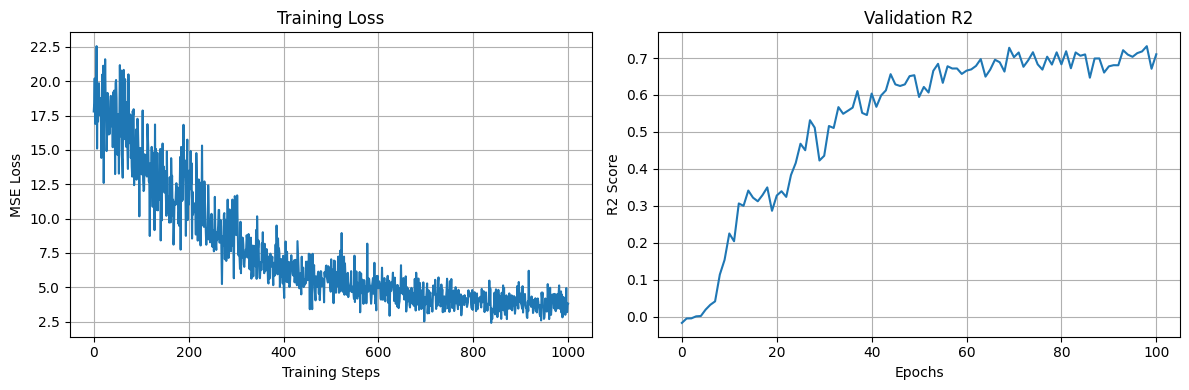

In [ ]:
seed_everything(0)

# 1. Setup datasets and dataloader
recording_id = "perich_miller_population_2018/t_20130819_center_out_reaching"
train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(recording_id, batch_size=64)
num_units = len(train_dataset.get_unit_ids())

# 2. Initialize Model
tf_model = TransformerNeuralDecoder(
    num_units=num_units,    # Num. of units inputted (spiking activity)
    #
    bin_size=10e-3,         # Duration (s) of bins
    sequence_length=1.0,    # Context length of the model
    #
    dim_output=2,           # Output dimension of final readout layer
    dim_hidden=128,         # Hidden dimension of the model
    n_layers=3,             # Num. of transformer layers
    n_heads=4,              # Num. of heads in MHA blocks
).to(device)

# 3. Connect Tokenizer to Datasets
train_dataset.transform = tf_model.tokenize
val_dataset.transform = tf_model.tokenize

# 4. Setup Optimizer
optimizer = torch.optim.AdamW(tf_model.parameters(), lr=1e-3)

# 5. Train!
transformer_r2_log, transformer_loss_log, transformer_train_outputs = train(tf_model, optimizer, train_loader, val_loader, num_epochs=100)

# Plot the training loss and validation R2
plot_training_curves(transformer_r2_log, transformer_loss_log)


### 2.3 Training POYO!

Here we show how we can instantiate a POYO model and train it from scratch.

From the figure below, we can see that the POYO model has a lot more going on internally in comparison to the two models we just saw. Thankfully, **torch_brain** provides implementations of standard neural decoding models that we can directly use in (almost) the same framework as we did with the previous models. We currently have implementations of POYO [3], and POYO+ [4], and are actively working on adding more models, such as NDT-2 [5], MTM [6], etc.

<center>
<img src="https://ik.imagekit.io/7tkfmw7hc/poyo.png?updatedAt=1743064332701" width=900/>
</center>

<!-- For custom models (and when training on a single session), it suffices to specify a single recording ID when defining the Dataset and DataLoaders, especially since things like normalization can be defined within the model definition. Since POYO was built for multi-session, it's important to define a more concrete configuration that allows for training across multiple sessions, or even multiple datasets. Here we simplify the process for the session we have been using, by declaring a simple `get_config` function that we can use whenever we train a POYO model. -->

Epoch 100/100 | Val R2 = 0.754 | Loss = 0.006
Done! Final validation R2 = 0.760


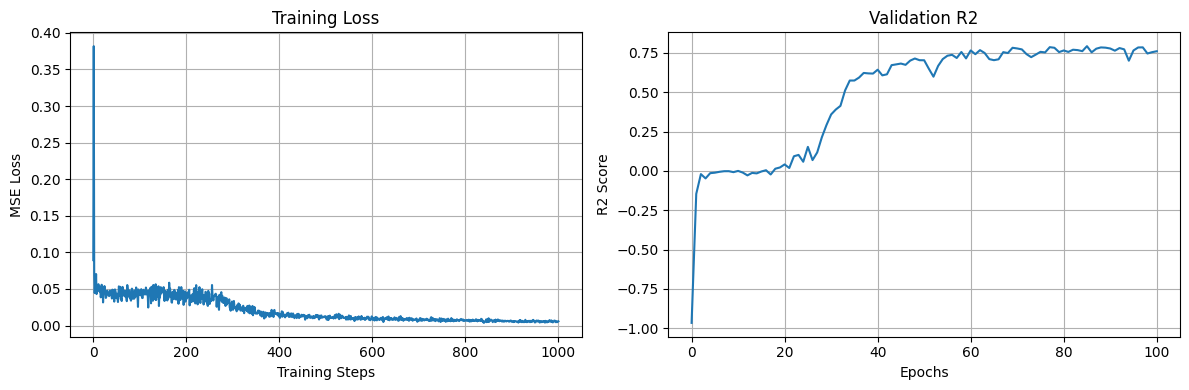

In [ ]:
seed_everything(0)

# 1. Setup datasets and dataloader
# For a model like POYO, which was built for multi-session training, the way to
# instantiate a dataset is just slightly more involved than what we have used
# so far. We have abstracted that difference in a utility function `get_dataset_config`
train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(
    cfg=get_dataset_config("perich_miller_population_2018", "t_20130819_center_out_reaching"),
    batch_size=64,
)

# 2. Instantiate the model. The model implementation is provided by torch_brain
from torch_brain.models import POYO
from torch_brain.registry import MODALITY_REGISTRY
poyo_model = POYO(
    sequence_length=1.0,                                    # Context length of the model
    readout_spec=MODALITY_REGISTRY['cursor_velocity_2d'],   # POYO allows for multiple readout modalities; this is how we choose
    #
    latent_step=1.0 / 8,                                    # Timestep of the learned latent grid
    num_latents_per_step=16,                                # Number of unique learned latents  per timestep
    #
    dim=64,                                                 # Hidden dimension of the model
    depth=6,                                                # Number of transformer layers
    #
    dim_head=64,                                            # Dimension of each attention head
    cross_heads=2,                                          # Num. of heads in cross-attention blocks
    self_heads=8,                                           # Num. of heads in self attention blocks
).to(device)

# 2.5: Extra step: populate the Unit and Session Embedding Vocabularies
poyo_model.unit_emb.initialize_vocab(train_dataset.get_unit_ids())
poyo_model.session_emb.initialize_vocab(train_dataset.get_session_ids())

# 3. Connect tokenizers to Datasets
train_dataset.transform = poyo_model.tokenize
val_dataset.transform = poyo_model.tokenize

# 4. Setup Optimizer
optimizer = torch.optim.AdamW(poyo_model.parameters(), lr=1e-3)

# 5. Train!
poyo_r2_log, poyo_loss_log, poyo_train_outputs = train(
  poyo_model, optimizer, train_loader, val_loader,
  num_epochs=100, store_embs=True,
)

# Plot the training loss and validation R2
plot_training_curves(poyo_r2_log, poyo_loss_log)

***

<a id="Finetuning"></a>
## Part 3. Finetuning and Visualizing

***

In the above sections, we saw that creating and training models for a single session of neural recordings, can be made quick and easy using **torch_brain**. In addition, standard models in **torch_brain** have been pretrained across different sessions, subjects, tasks, and even datasets. We can utilize the generalization capabilities of these scaled up models, and *fine-tune* them on new data with minimal effort.

In this section, we will demonstrate how to fine-tune a pretrained POYO-mp model on a new session. We note that the session we've
been using so far (`t_20130819_center_out_reaching`) was held out of POYO-mp pretraining.

***
### Table of contents:
* 3.1 Loading a Pretrained Model
* 3.2 Finetuning Strategies
* 3.3 Let's fine-tune!
* 3.4 Let's compare
* 3.5 Visualizing the POYO model

### 3.1 Loading a Pretrained Model
First we will download the POYO-MP pretrained checkpoint.

In [ ]:
! uv pip install boto3 -q
import boto3
from botocore import UNSIGNED
from botocore.config import Config

# Download the pretrained model
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3.download_file(
    "torch-brain",
    "model-zoo/poyo_mp.ckpt",
    "poyo_mp.ckpt"
)


### 3.2 Finetuning Strategies

As a reminder, POYO learns an embedding space for units and sessions that is shared across all its training data. When fine-tuning POYO on a new session, we need to find how to project the new units and session into the previously learned embedding space. For this we keep most of the model weights unchanged and only train the new embeddings (we call this *freezing the backbone*). We can opt to unfreeze them after a certain number of epochs, or keep them frozen throughout.

<center>
  <img src="https://drive.google.com/uc?export=view&id=1cFrUfa20BXwUFF4VV0JZXtjcK2iL3z3c" width=300 />
</center>

#### Finetuning function

Depending on the value of `epoch_to_unfreeze`, we have different fine-tuning strategies:
- **Full fine-tuning** (with gradual unfreezing): if we set `epoch_to_unfreeze >= 0` then we will train the new embeddings for `epoch_to_unfreeze` epochs,
then unfreeze the backbone and train the entire model for the remaining epochs.
- **Unit Identification**: if we set `epoch_to_unfreeze == -1`, then we will only train the new embeddings for all epochs, i.e. the backbone
will remain frozen throughout training.

For this we'll define a new training function that allows for different fine-tuning strategies (it's otherwise the same as the previous training function).

In [ ]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

def finetune(model, optimizer, train_loader, val_loader, num_epochs=50, epoch_to_unfreeze=30):
    # Freeze the backbone
    backbone_params = [
        p for p in model.named_parameters()
        if (
            'unit_emb' not in p[0]
            and 'session_emb' not in p[0]
            and 'readout' not in p[0]
            and p[1].requires_grad
        )
    ]
    for _, param in backbone_params:
        param.requires_grad = False

    # We'll store some intermediate outputs for visualization
    train_outputs = {
        'n_epochs': num_epochs,
        'epoch_to_unfreeze': epoch_to_unfreeze,
        'unit_emb': [],
        'session_emb': [],
        'output_pred': [],
        'output_gt': [],
    }

    r2_log = []
    loss_log = []

    # Training loop
    for epoch in range(num_epochs):
        # Unfreeze the backbone after `epoch_to_unfreeze` epochs
        if epoch == epoch_to_unfreeze:
            for _, param in backbone_params:
                param.requires_grad = True
            print(" Unfreezing entire model")

        with torch.no_grad():
            r2, target, pred = compute_r2(val_loader, model)
            r2_log.append(r2)

        for batch in train_loader:
            batch = move_to_gpu(batch, device)
            loss = training_step(batch, model, optimizer)
            loss_log.append(loss.item())

        print(f"\rEpoch {epoch+1}/{num_epochs} | Val R2 = {r2:.3f} | Loss = {loss.item():.3f}", end="")

        # Store intermediate outputs
        train_outputs['unit_emb'].append(model.unit_emb.weight[1:].detach().cpu().numpy())
        train_outputs['session_emb'].append(model.session_emb.weight[1:].detach().cpu().numpy())
        train_outputs['output_gt'].append(target.detach().cpu().numpy())
        train_outputs['output_pred'].append(pred.detach().cpu().numpy())

        del target, pred

    # Compute final R² score
    r2, _, _ = compute_r2(val_loader, model)
    r2_log.append(r2)
    print(f"\nDone! Final validation R2 = {r2:.3f}")

    return r2_log, loss_log, train_outputs

### 3.3 Let's fine-tune!
Note: the model was pretrained with the fixed vocabulary of units and sessions used during training. Since we are now fine-tuning on a new session (with new units), we extend the vocabulary to include the new units and session, then subset the vocabulary to only look at
the new ones.

Here we'll put the full training workflow into a function as well so we can easily repeat it for different sessions or
finetuning strategies. Of course, if one wishes to manually implement a more complex training loop, they can do so as well.

Loading pretrained model...
Done!
Epoch 10/40 | Val R2 = 0.601 | Loss = 0.015 Unfreezing entire model
Epoch 40/40 | Val R2 = 0.747 | Loss = 0.002
Done! Final validation R2 = 0.731


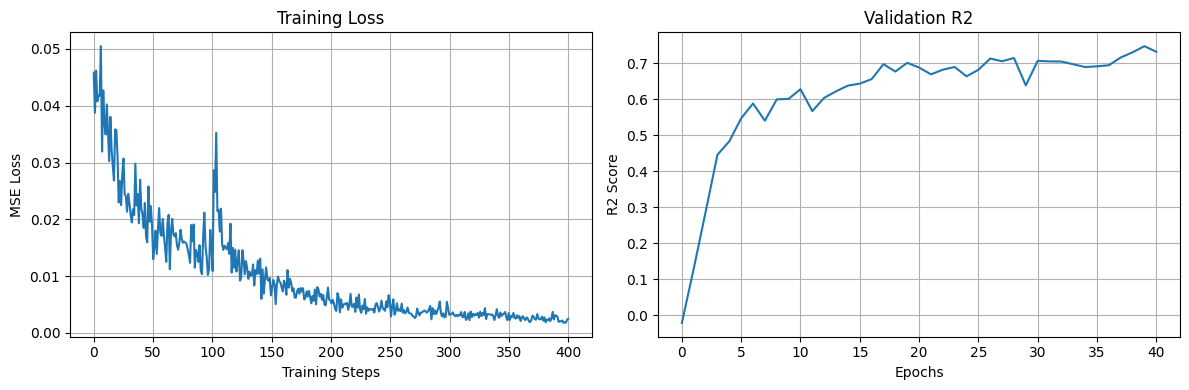

In [ ]:
seed_everything(0)

# 1. Setup datasets and dataloader
train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(
    cfg=get_dataset_config("perich_miller_population_2018", "t_20130819_center_out_reaching"),
    batch_size=64,
)
num_units = len(train_dataset.get_unit_ids())

# 2. Instantiate the model and load pretrained weights (with poyo-mp hparams)
from torch_brain.models import POYO
from torch_brain.registry import MODALITY_REGISTRY
poyo_ft_model = POYO(
    sequence_length=1.0,
    latent_step=1.0 / 8,
    dim=128,
    readout_spec=MODALITY_REGISTRY['cursor_velocity_2d'],
    dim_head=64,
    num_latents_per_step=32,
    depth=24,
    cross_heads=4,
    self_heads=8,
)

ckpt_path = 'poyo_mp.ckpt'
poyo_ft_model = load_pretrained(ckpt_path, poyo_ft_model)

# 2.5. Reinitialize the vocabs for the new session
reinit_vocab(poyo_ft_model.unit_emb, train_dataset.get_unit_ids())
reinit_vocab(poyo_ft_model.session_emb, train_dataset.get_session_ids())

poyo_ft_model.to(device)

# 3. Connect tokenizers to Datasets
train_dataset.transform = poyo_ft_model.tokenize
val_dataset.transform = poyo_ft_model.tokenize

# 4. Setup Optimizer
optimizer = torch.optim.AdamW(poyo_ft_model.parameters(), lr=1e-3)

# 5. Train!
poyo_ft_r2_log, poyo_ft_loss_log, poyo_ft_train_outputs = finetune(poyo_ft_model, optimizer, train_loader, val_loader,
                                          num_epochs=40, epoch_to_unfreeze=10)

# Visualize the results
plot_training_curves(poyo_ft_r2_log, poyo_ft_loss_log)

### 3.4 Let's compare

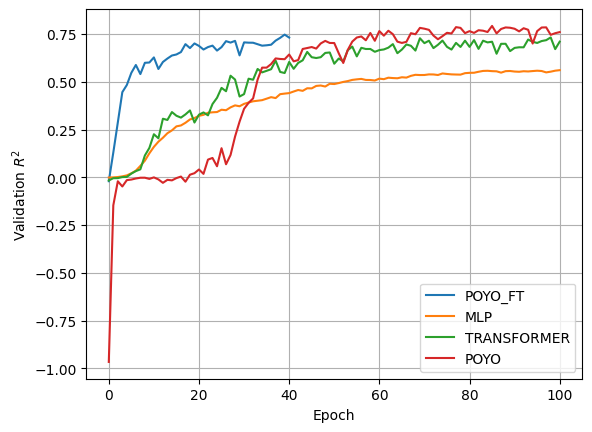

In [ ]:
lcls = locals().copy()
for lcl in lcls:
    if not lcl.endswith("_r2_log"):
        continue
    model = lcl.split("_r2_log")[0].upper()
    plt.plot(locals()[lcl], label=model)
plt.xlabel("Epoch")
plt.ylabel("Validation $R^2$")
plt.grid()
plt.legend()
plt.show()

### 3.5 Visualizing the POYO model

POYO's unit and session embeddings are learned during training, and we can visualize them along with a snapshot of the
model's performance.

#### Visualization utilities

Just run this block.

In [ ]:
from sklearn.decomposition import PCA
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, CustomJS, Div, Spacer
from bokeh.layouts import column, row
from bokeh.io import output_notebook
from bokeh.palettes import Pastel1

# visualize_training(model, train_outputs, prev_session_emb, prev_session_emb_labels, n_epochs, epoch_to_unfreeze):
def visualize_training(model, ckpt, train_outputs):
    n_epochs = train_outputs["n_epochs"]
    epoch_to_unfreeze = train_outputs.get("epoch_to_unfreeze", 0)
    # Extract info from "finetuned" model
    cur_session_emb_labels = list(model.session_emb.vocab.keys())[1:]
    # Extract info from "pretrained" model
    if ckpt is not None and ckpt != "":
        ckpt_data = torch.load(ckpt, weights_only=False, map_location="cpu")
        prev_session_emb = ckpt_data['state_dict']['model.session_emb.weight'][1:].detach().clone()
        prev_session_emb_labels = [str(x) for x in ckpt_data['state_dict']['model.session_emb.vocab']][1:]
    else:
        prev_session_emb = np.zeros((0, model.dim))
        prev_session_emb_labels = []

    n_units = train_outputs['unit_emb'][0].shape[0]
    n_sessions = train_outputs['session_emb'][0].shape[0]
    n_prev_sessions = prev_session_emb.shape[0]

    pca = PCA(n_components=2)
    flat_unit_emb = np.concatenate(train_outputs['unit_emb'], axis=0) # (n_epochs*n_units, emb_dim)
    unit_emb_pca = pca.fit_transform(flat_unit_emb) # (n_epochs*n_units, 2)
    unit_emb_x = unit_emb_pca[:, 0]
    unit_emb_y = unit_emb_pca[:, 1]

    total_session_emb = np.concatenate([prev_session_emb, # (n_prev_sessions+n_epochs*n_sessions, emb_dim)
                                        *train_outputs['session_emb']], axis=0)
    session_emb_pca = pca.fit_transform(total_session_emb) # (n_prev_sessions+n_epochs*n_sessions, 2)
    session_emb_x = session_emb_pca[:, 0]
    session_emb_y = session_emb_pca[:, 1]

    sampling_rate = 100
    sample_out_start = 2000
    sample_out_end = sample_out_start + 500
    pred_x = np.concatenate([output[sample_out_start:sample_out_end, 0] for output in train_outputs['output_pred']])
    pred_y = np.concatenate([output[sample_out_start:sample_out_end, 1] for output in train_outputs['output_pred']])
    gt_x = np.concatenate([output[sample_out_start:sample_out_end, 0] for output in train_outputs['output_gt']])
    gt_y = np.concatenate([output[sample_out_start:sample_out_end, 1] for output in train_outputs['output_gt']])

    _Pastel1 = Pastel1.copy()
    _Pastel1 = {**_Pastel1, **{i: _Pastel1[3][:i] for i in range(1, 3)}}  # for some reason only starts at 3
    all_session_emb_labels = prev_session_emb_labels + cur_session_emb_labels
    extract_sess_label_grp = lambda label: label.split('/')[0] + '/' + label.split('/')[1].split('_')[0]
    all_sess_emb_label_grps = [extract_sess_label_grp(label) for label in all_session_emb_labels]  # map to <brainset/xx>_...
    unique_sess_emb_label_grps = list(set(all_sess_emb_label_grps))
    unique_sess_emb_label_grp_map = {label: i for i, label in enumerate(unique_sess_emb_label_grps)}  # create index map for unique labels
    all_sess_emb_label_grp_idx = [unique_sess_emb_label_grp_map[label] for label in all_sess_emb_label_grps]  # map labels to index

    # Generate pastel colors based on unique labels
    unique_labels = np.unique(all_sess_emb_label_grp_idx)
    color_map = {label: _Pastel1[len(unique_labels)][i % len(_Pastel1[len(unique_labels)])] for i, label in enumerate(unique_labels)}

    # Assign colors based on group index
    colors = np.array([color_map[label] for label in all_sess_emb_label_grp_idx])

    # Define border color: Only sessions after `n_prev_sessions` should have a border
    border_colors = np.array(['black' if i >= n_prev_sessions else None for i in range(n_prev_sessions+n_sessions)])

    # Enable inline visualization in Jupyter Notebook
    output_notebook()

    # Data sources
    unit_source = ColumnDataSource(data={'x': unit_emb_x[:n_units], 'y': unit_emb_y[:n_units]})
    sess_source = ColumnDataSource(data={
        'x': np.concatenate([session_emb_x[:n_prev_sessions],
                            session_emb_x[n_prev_sessions:n_prev_sessions+n_sessions]]),
        'y': np.concatenate([session_emb_y[:n_prev_sessions],
                            session_emb_y[n_prev_sessions:n_prev_sessions+n_sessions]]),
        'color': colors,
        'border_color': border_colors,
    })

    time = np.linspace(0, (sample_out_end-sample_out_start)/sampling_rate, sample_out_end-sample_out_start)
    pred_source_x = ColumnDataSource(data={'x': time, 'y': pred_x[:sample_out_end-sample_out_start]})
    pred_source_y = ColumnDataSource(data={'x': time, 'y': pred_y[:sample_out_end-sample_out_start]})
    gt_source_x = ColumnDataSource(data={'x': time, 'y': gt_x[:sample_out_end-sample_out_start]})
    gt_source_y = ColumnDataSource(data={'x': time, 'y': gt_y[:sample_out_end-sample_out_start]})

    # Define plot ranges with buffer
    buffer = 0.1
    unit_x_min, unit_x_max = np.min(unit_emb_x), np.max(unit_emb_x)
    unit_y_min, unit_y_max = np.min(unit_emb_y), np.max(unit_emb_y)
    sess_x_min, sess_x_max = np.min(session_emb_x), np.max(session_emb_x)
    sess_y_min, sess_y_max = np.min(session_emb_y), np.max(session_emb_y)
    unit_buffer_x, unit_buffer_y = buffer * abs(unit_x_min - unit_x_max), buffer * abs(unit_y_min - unit_y_max)
    unit_buffer_x, unit_buffer_y = 0.01 if unit_buffer_x == 0 else unit_buffer_x, 0.01 if unit_buffer_y == 0 else unit_buffer_y
    sess_buffer_x, sess_buffer_y = buffer * abs(sess_x_min - sess_x_max), buffer * abs(sess_y_min - sess_y_max)
    sess_buffer_x, sess_buffer_y = 0.01 if sess_buffer_x == 0 else sess_buffer_x, 0.01 if sess_buffer_y == 0 else sess_buffer_y
    unit_x_range = (unit_x_min - unit_buffer_x, unit_x_max + unit_buffer_x)
    unit_y_range = (unit_y_min - unit_buffer_y, unit_y_max + unit_buffer_y)
    sess_x_range = (sess_x_min - sess_buffer_x, sess_x_max + sess_buffer_x)
    sess_y_range = (sess_y_min - sess_buffer_y, sess_y_max + sess_buffer_y)
    unit_plot = figure(title="Unit Embeddings", x_axis_label="PC1", y_axis_label="PC2", width=300, height=300, background_fill_color="white",
                    x_range=unit_x_range, y_range=unit_y_range)

    sess_plot = figure(title="Session Embeddings", x_axis_label="PC1", y_axis_label="PC2", width=300, height=300, background_fill_color="white",
                    x_range=sess_x_range, y_range=sess_y_range)

    # Unit embedding plot
    unit_plot.scatter('x', 'y', source=unit_source, size=10, alpha=0.7, color='lightblue', line_color='black')

    # Session embedding plot
    sess_plot.scatter('x', 'y', source=sess_source, size=10, alpha=0.7, color='color', line_color='border_color')

    # Hand velocity plots
    vx_min, vx_max = np.min(np.concatenate([pred_x, gt_x])), np.max(np.concatenate([pred_x, gt_x]))
    vx_range = (vx_min - buffer * abs(vx_min), vx_max + buffer * abs(vx_max))
    vx_plot = figure(title="Hand Velocity - Vx", x_axis_label="Time (s)", y_axis_label="Velocity", width=300, height=150, background_fill_color="white"
                        , y_range=vx_range)
    vx_plot.line('x', 'y', source=pred_source_x, color='red')
    vx_plot.line('x', 'y', source=gt_source_x, color='black')

    vy_min, vy_max = np.min(np.concatenate([pred_y, gt_y])), np.max(np.concatenate([pred_y, gt_y]))
    vy_range = (vy_min - buffer * abs(vy_min), vy_max + buffer * abs(vy_max))
    vy_plot = figure(title="Hand Velocity - Vy", x_axis_label="Time (s)", y_axis_label="Velocity", width=300, height=150, background_fill_color="white"
                        , y_range=vy_range)
    vy_plot.line('x', 'y', source=pred_source_y, color='blue')
    vy_plot.line('x', 'y', source=gt_source_y, color='black')

    # Model diagram
    if epoch_to_unfreeze == 0:
        model_diagram = Div(text='<img src="https://media-hosting.imagekit.io//33c2439b9dc549dc/unit-id-unfrozen.svg?Expires=1837453466&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=i4i4qMNDJhiTEfC-Uo-DhSaxCUVsrN9W7m7mL4RDWPaRHrhsCXuIXsjPzTksoIQobZr9qMGVRNwTpDD-jGIT1-Y2K42H5uXY37WXNfBhHzcb-GsyYAjx9ztVuYi9OAeaiZdtXe-Yc-xQF88RWsBdSBw0KA26Ewwj2CcuBoexlSL3rNttoWMHVzyisTDFyX2N1uYmpnRbKFarnU0Xvn9OXx2y64fgZyT8oGgbYShjHZApDqEujfRubXwrvH86etyPvuzvbzqMxc27u-BgMQv0l--qsq2tP3y66AhQu~EuwbU9E4Dxud94bekO7ZE9a5TT1o0IafHMYqadXVSAARf9EQ__" width="400">', width=400, height=400)
    else:
        model_diagram = Div(text='<img src="https://media-hosting.imagekit.io//7bc43a35ec174ef4/unit-id-frozen.svg?Expires=1837453466&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=CylM3BrCyxTkiRd2DaTpqU~Q2gwDYBH8LjmL0Duv5ybgWMegyrYWfDVmu4weQx~bM7Dbd2BJ3Q-83WhSVRNRTBEzq3Dkr-RjuPdhbBAKhL-0Ku7aC4eo~EetHwa5PeuYGsQvs0jFaQF-XRv3Ow04kxww8m9gAgLTuDyL6-2FYf~68EXGrD0A6GqYeozU65~nwptnzF~YVu2gYsp5ERTOdbyE5TjNIKp21QBwhQ~BkbZ5NEfvITkdvbTv9j1k2p5hmxW~jm15Llz-oxj2l-l2fM~3UZ8JC6NHze~lTqmANrrxf0GIEYBAAwvDWj6QcSmZXieGB2CbjDXp5jpJyqu34g__" width="400">', width=400, height=400)

    # Widgets
    slider = Slider(start=0, end=n_epochs-1, value=0, step=1, title="Epoch")

    callback = CustomJS(args=dict(source1=unit_source, source2=sess_source, source3=pred_source_x, source4=pred_source_y,
                                source5=gt_source_x, source6=gt_source_y,
                                unit_x=unit_emb_x, unit_y=unit_emb_y, sess_x=session_emb_x, sess_y=session_emb_y, #cat=session_cat,
                                n_units=n_units, n_sessions=n_sessions, n_prev_sessions=n_prev_sessions,
                                diagram=model_diagram, unfreeze_epoch=epoch_to_unfreeze,
                                pred_x=pred_x, pred_y=pred_y, gt_x=gt_x, gt_y=gt_y,
                                samples=sample_out_end-sample_out_start,
                                ),#pred_x=pred_x, pred_y=pred_y),
                        code="""
        var step = cb_obj.value;
        source1.data.x = unit_x.slice(step*n_units, (step+1)*n_units);
        source1.data.y = unit_y.slice(step*n_units, (step+1)*n_units);

        let prev_sess_x = sess_x.slice(0, n_prev_sessions);
        let cur_sess_x = sess_x.slice(n_prev_sessions+n_sessions*step, n_prev_sessions+n_sessions*(step+1));
        source2.data.x = Array.from(prev_sess_x).concat(Array.from(cur_sess_x));
        let prev_sess_y = sess_y.slice(0, n_prev_sessions);
        let cur_sess_y = sess_y.slice(n_prev_sessions+n_sessions*step, n_prev_sessions+n_sessions*(step+1));
        source2.data.y = Array.from(prev_sess_y).concat(Array.from(cur_sess_y));

        source3.data.y = pred_x.slice(step*samples, (step+1)*samples);
        source4.data.y = pred_y.slice(step*samples, (step+1)*samples);
        source5.data.y = gt_x.slice(step*samples, (step+1)*samples);
        source6.data.y = gt_y.slice(step*samples, (step+1)*samples);

        source1.change.emit();
        source2.change.emit();
        source3.change.emit();
        source4.change.emit();
        source5.change.emit();
        source6.change.emit();

        if (unfreeze_epoch >= 0 && step >= unfreeze_epoch) {
            diagram.text = '<img src="https://media-hosting.imagekit.io//33c2439b9dc549dc/unit-id-unfrozen.svg?Expires=1837453466&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=i4i4qMNDJhiTEfC-Uo-DhSaxCUVsrN9W7m7mL4RDWPaRHrhsCXuIXsjPzTksoIQobZr9qMGVRNwTpDD-jGIT1-Y2K42H5uXY37WXNfBhHzcb-GsyYAjx9ztVuYi9OAeaiZdtXe-Yc-xQF88RWsBdSBw0KA26Ewwj2CcuBoexlSL3rNttoWMHVzyisTDFyX2N1uYmpnRbKFarnU0Xvn9OXx2y64fgZyT8oGgbYShjHZApDqEujfRubXwrvH86etyPvuzvbzqMxc27u-BgMQv0l--qsq2tP3y66AhQu~EuwbU9E4Dxud94bekO7ZE9a5TT1o0IafHMYqadXVSAARf9EQ__" width="400">';
        } else {
            diagram.text = '<img src="https://media-hosting.imagekit.io//7bc43a35ec174ef4/unit-id-frozen.svg?Expires=1837453466&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=CylM3BrCyxTkiRd2DaTpqU~Q2gwDYBH8LjmL0Duv5ybgWMegyrYWfDVmu4weQx~bM7Dbd2BJ3Q-83WhSVRNRTBEzq3Dkr-RjuPdhbBAKhL-0Ku7aC4eo~EetHwa5PeuYGsQvs0jFaQF-XRv3Ow04kxww8m9gAgLTuDyL6-2FYf~68EXGrD0A6GqYeozU65~nwptnzF~YVu2gYsp5ERTOdbyE5TjNIKp21QBwhQ~BkbZ5NEfvITkdvbTv9j1k2p5hmxW~jm15Llz-oxj2l-l2fM~3UZ8JC6NHze~lTqmANrrxf0GIEYBAAwvDWj6QcSmZXieGB2CbjDXp5jpJyqu34g__" width="400">';
        }
    """)

    slider.js_on_change('value', callback)

    # Improved Layout Structure
    layout = column(
        slider,
        row(
            column(unit_plot, sess_plot),
            model_diagram,
            column(Spacer(height=80), vx_plot, vy_plot)
        ),
        styles={
            "background-color": "white",
            "padding": "20px",
        }
    )

    show(layout, notebook_handle=True)

#### Visualize

We can visualize the training of POYO from scratch:

In [ ]:
visualize_training(poyo_model, ckpt=None, train_outputs=poyo_train_outputs)

Or from POYO fine-tuning:

In [ ]:
visualize_training(poyo_ft_model, ckpt="poyo_mp.ckpt", train_outputs=poyo_ft_train_outputs)

***

## Part 4. Your Turn!

***
Now that you've seen how to train and fine-tune models on neural data, try experimenting on your own! Here are three exercises from us with varying levels of difficulty.

### 4.1 Exercise (a): Easy

In the transformer implementation in Part 2.2, change the positional embeddings from being fixed (i.e. non learnable) to being learnable, and train the transformer from scratch. Note that since we have limited training data, we won't observe an improvement in performance by making this switch.


#### Solution

In [ ]:
from torch_brain.nn import FeedForward

class TransformerNeuralDecoder(nn.Module):
    def __init__(
        self, num_units, bin_size, sequence_length,   # data properties
        dim_output, dim_hidden, n_layers, n_heads,    # transformer properties
    ):
        """Initialize the neural net components"""
        super().__init__()

        self.num_timesteps = int(sequence_length / bin_size)
        self.bin_size = bin_size

        self.readin = nn.Linear(num_units, dim_hidden)
        self.readout = nn.Linear(dim_hidden, dim_output)

        self.position_embeddings = nn.Parameter(
            data=generate_sinusoidal_position_embs(self.num_timesteps, dim_hidden),
            requires_grad=True,     ##### <<<<<< SOLUTION: CHANGED TO TRUE
        )

        self.transformer_layers = nn.ModuleList([
            nn.ModuleList([
                nn.MultiheadAttention(
                    embed_dim=dim_hidden,
                    num_heads=n_heads,
                    batch_first=True,
                ),
                FeedForward(dim=dim_hidden),
            ])
            for _ in range(n_layers)
        ])

    def forward(self, x):
        # Remains unchanged

        x = self.readin(x)  # (B, T, N) -> (B, T, D)
        x = x + self.position_embeddings[None, ...]  # -> (B, T, D)
        for attn, ffn in self.transformer_layers:
            x = x + attn(x, x, x, need_weights=False)[0]
            x = x + ffn(x)
        x = self.readout(x)  # (B, T, D) -> (B, T, 2)

        return x

    def tokenize(self, data):
        # Remains unchanged

        x = bin_spikes(
            spikes=data.spikes,
            num_units=len(data.units),
            bin_size=self.bin_size,
            num_bins=self.num_timesteps,
        ).T
        y = data.cursor.vel
        data_dict = {
            "model_inputs": {
                "x": torch.tensor(x, dtype=torch.float32),
            },
            "target_values": torch.tensor(y, dtype=torch.float32),
        }
        return data_dict

In [ ]:
seed_everything(0)

# 1. Setup datasets and dataloader
recording_id = "perich_miller_population_2018/t_20130819_center_out_reaching"
train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(recording_id, batch_size=64)
num_units = len(train_dataset.get_unit_ids())

# 2. Initialize Model
tf_model = TransformerNeuralDecoder(
    num_units=num_units,
    bin_size=10e-3,
    sequence_length=1.0,
    dim_output=2,
    dim_hidden=128,
    n_layers=3,
    n_heads=4,
).to(device)

# 3. Connect Tokenizer to Datasets
train_dataset.transform = tf_model.tokenize
val_dataset.transform = tf_model.tokenize

# 4. Setup Optimizer
optimizer = torch.optim.AdamW(tf_model.parameters(), lr=1e-3)

# 5. Train!
transformer_r2_log, transformer_loss_log, transformer_train_outputs = train(tf_model, optimizer, train_loader, val_loader, num_epochs=100)

# Plot the training loss and validation R2
plot_training_curves(transformer_r2_log, transformer_loss_log)

You might observe that this model does not perform as well as the the version in Part 2.2 where the position embeddings were fixed. This can be attributed to overfitting, now that we can train a lot more parameters (the position embeddings!).

### 4.2 Exercise (b): Medium (Multi-Session Training!)

Throughout this notebook, we have been training on a single session (`t_20130819_center_out_reaching`) which includes recordings from a single monkey during a reaching task. What if we want to train on multiple sessions? We noted in Part 2.3 that the configuration used to setup data for training POYO allows for loading multiple sessions, as well as some more complex configurations.

In this exercise, we'll train on two separate sessions from the same monkey during the reaching task. The new session is called `t_20130821_center_out_reaching` and includes recordings from a later date than the first one. Note that we might be interested in training across different animals or tasks as well, but we are limited by the model capacity.

First, download the new session below:


In [ ]:
!gdown 1EZUkOE8oiieWja9lblokf8WjF05HFuX- -O data/perich_miller_population_2018/t_20130821_center_out_reaching.h5

Downloading...
From: https://drive.google.com/uc?id=1EZUkOE8oiieWja9lblokf8WjF05HFuX-
To: /content/data/perich_miller_population_2018/t_20130821_center_out_reaching.h5
100% 10.4M/10.4M [00:00<00:00, 51.1MB/s]


Now, setup train and validation DataLoaders such that training will be across both sessions, but validation will stay only on the first session (so we can directly compare). Then, train POYO on the two sessions for 50 epochs (half of that from original training).

**Tips**:

* `get_dataset_config` accepts both a single session as a string (as we've seen so far), or a list of sessions:

```get_dataset_config(brainset, [session1, session2, ...])```
*   You cannot use `get_train_val_loaders` directly since it uses the same config for both train and val

#### Solution

In [ ]:
# -- Train --
train_dataset = Dataset(
    root="data",
    config=get_dataset_config("perich_miller_population_2018", [
        "t_20130819_center_out_reaching",
        "t_20130821_center_out_reaching",  # <<<<<< SOLUTION: ADDED
    ]),
    split="train",
)
train_sampling_intervals = train_dataset.get_sampling_intervals()
train_sampler = RandomFixedWindowSampler(
    sampling_intervals=train_sampling_intervals,
    window_length=1.0,
)
train_loader = DataLoader(
    dataset=train_dataset,
    sampler=train_sampler,
    batch_size=64,
    collate_fn=collate,
    num_workers=4,
    pin_memory=True,
)

# -- Validation --
val_dataset = Dataset(
    root="data",
    config=get_dataset_config("perich_miller_population_2018", "t_20130819_center_out_reaching"),
    split="valid",
)
val_sampling_intervals = val_dataset.get_sampling_intervals()
val_sampler = SequentialFixedWindowSampler(
    sampling_intervals=val_sampling_intervals,
    window_length=1.0,
)
val_loader = DataLoader(
    dataset=val_dataset,
    sampler=val_sampler,
    batch_size=64,
    collate_fn=collate,
    num_workers=4,
    pin_memory=True,
)

train_dataset.disable_data_leakage_check()
val_dataset.disable_data_leakage_check()

Epoch 100/100 | Val R2 = 0.770 | Loss = 0.004
Done! Final validation R2 = 0.781


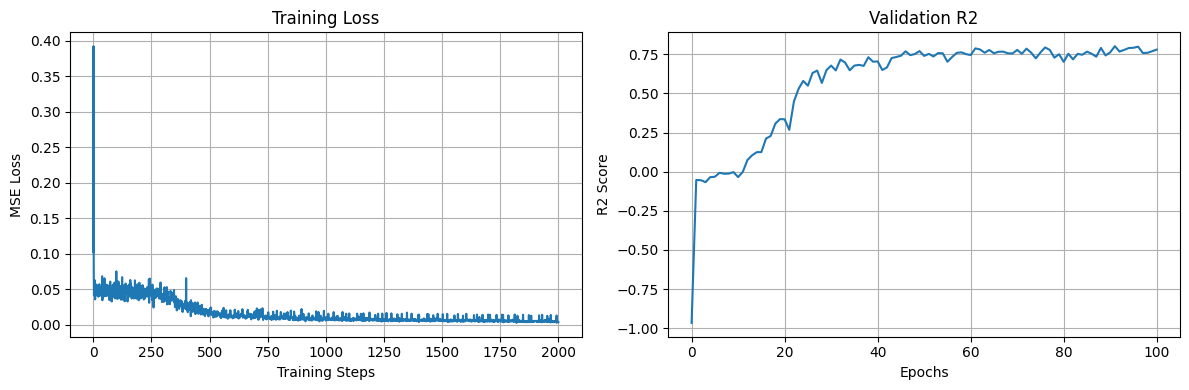

In [ ]:
# Training is same as we did before

seed_everything(0)

from torch_brain.models import POYO
from torch_brain.registry import MODALITY_REGISTRY
poyo_model = POYO(
    sequence_length=1.0,
    readout_spec=MODALITY_REGISTRY['cursor_velocity_2d'],
    latent_step=1.0 / 8,
    num_latents_per_step=16,
    dim=64,
    depth=6,
    dim_head=64,
    cross_heads=2,
    self_heads=8,
).to(device)

poyo_model.unit_emb.initialize_vocab(train_dataset.get_unit_ids())
poyo_model.session_emb.initialize_vocab(train_dataset.get_session_ids())

train_dataset.transform = poyo_model.tokenize
val_dataset.transform = poyo_model.tokenize

optimizer = torch.optim.AdamW(poyo_model.parameters(), lr=1e-3)

poyo_r2_log, poyo_loss_log, poyo_train_outputs = train(
  poyo_model, optimizer, train_loader, val_loader,
  num_epochs=100, store_embs=True,
)

plot_training_curves(poyo_r2_log, poyo_loss_log)

Once the training is done you can see that just by training on another session the validation performance on the original session improves slighly. You can imagine it's not too much more work to then train at the scale of POYO and POYO+ with this setup. Just keep scaling up the dataset size (and model size as well) and performance will keep on improving.

### 4.3 Exercise (c): Medium

In our MLP model in Part 2.1, we had intentionally set `bin_size` equal to the sampling period of the behavior output (10ms) to simplify the code. Now that you are more accustomed to the framework, make `bin_size` independent of the `output_sampling_period`. The signature of the MLP model should be:

```python
class MLPNeuralDecoder(nn.Module):
    def __init__(
      self, num_units, bin_size, sequence_length,
      output_sampling_period,   # NEW ARGUMENT!
      output_dim, hidden_dim,
    ):
      ...
```

Once you're done modifying the model, train it with `bin_size=20e-3`, and `output_sampling_period=10e-3`.

#### Solution

In [ ]:
import torch.nn as nn

class MLPNeuralDecoder(nn.Module):
    def __init__(self, num_units, bin_size, sequence_length, output_sampling_period, output_dim, hidden_dim):
        """Initialize the neural net layers."""
        super().__init__()

        self.num_input_timesteps = int(sequence_length / bin_size)  # CHANGE
        self.num_output_timesteps = int(sequence_length / output_sampling_period)  # CHANGE
        self.bin_size = bin_size

        self.net = nn.Sequential(
            nn.Linear(self.num_input_timesteps * num_units, hidden_dim),  # CHANGE
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * self.num_output_timesteps),  # CHANGE
        )

    def forward(self, x):
        x = x.flatten(1)
        x = self.net(x)
        x = x.reshape(-1, self.num_output_timesteps, 2)  # CHANGE
        return x

    def tokenize(self, data):
        spikes = data.spikes
        x = bin_spikes(
            spikes=spikes,
            num_units=len(data.units),
            bin_size=self.bin_size,
            num_bins=self.num_input_timesteps  # CHANGE
        ).T
        y = data.cursor.vel
        data_dict = {
            "model_inputs": {
                "x": torch.tensor(x, dtype=torch.float32),
            },
            "target_values": torch.tensor(y, dtype=torch.float32),
        }
        return data_dict

In [ ]:
seed_everything(0)

# 1. Setup datasets and dataloader
recording_id = "perich_miller_population_2018/t_20130819_center_out_reaching"
train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(recording_id, batch_size=64)
num_units = len(train_dataset.get_unit_ids())
print(f"Num Units in Session: {num_units}")

# 2. Initialize Model with the new MLP definition
mlp_model = MLPNeuralDecoder(
    num_units=num_units,
    bin_size=20e-3,                   # CHANGE
    sequence_length=1.0,
    output_sampling_period=10e-3,     # CHANGE
    output_dim=2,
    hidden_dim=32,
)
mlp_model = mlp_model.to(device)

# 3. Connect Tokenizer to Datasets
transform = mlp_model.tokenize
train_dataset.transform = transform
val_dataset.transform = transform

# 4. Setup Optimizer
optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=1e-3)

# 5. Train!
mlp_r2_log, mlp_loss_log, mlp_train_outputs = train(mlp_model, optimizer, train_loader, val_loader, num_epochs=100)

# Plot the training loss and validation R2
plot_training_curves(mlp_r2_log, mlp_loss_log)

### 4.4 Exercise (d): Challenging

So far in all our examples, we've been using the full set of recorded units for decoding. It turns out that the session includes recordings of spiking activity from neurons in both the monkey Premotor Cortex (PMd) and Primary Motor Cortex (M1). What if we restrict our model to only decode from neurons in the PMd?

For this exercise, note that the brain regions of the units can be found directly in the unit IDs (refer to training code from any of the examples to see how to access these IDs). Given these, change the Transformer code from Part 2.2 to:

(i) First explore the unit IDs to figure out how to extract and filter on the brain region.

(ii) Write a new tokenizer that, given a batch of samples from both brain regions, creates tokens only from the PMd neurons.

(iii) Instantiate a Transformer model with number of units restricted based only to PMd neurons.

(iv) Train the Transformer model using your new tokenizer, and compare results to training on all neurons.

**Question**: We are dropping the number of units the model is trained on, but in the process reducing the training to data from the same brain region. Given these, should we expect model performance to increase or decrease?

**Tip**: save `r2_log` and `loss_log` as different names than before (e.g., `transformer_r2_log`) so you retain both for comparison.

#### Solution

##### (i) Solution

In [ ]:
# Setup data loaders
seed_everything(0)
recording_id = "perich_miller_population_2018/t_20130819_center_out_reaching"
train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(recording_id, batch_size=64)

# Explore the unit ids
unit_ids = train_dataset.get_unit_ids()
for unit_id in unit_ids[:5] + unit_ids[-5:]:
    print(unit_id)

We can see that the unit IDs directly contain the brain region (between M1 and PMd). Hence filtering is fairly straightforward:

In [ ]:
# Filter on PMd neurons
pmd_units = [unit_id for unit_id in unit_ids if 'PMd' in unit_id]
for unit_id in pmd_units[:5] + pmd_units[-5:]:
    print(unit_id)

##### (ii) Solution

In [ ]:
# We adapt the Transformer implementation from Part 2.2
class TransformerNeuralDecoder(nn.Module):
    def __init__(
        self, num_units, bin_size, sequence_length,
        dim_output, dim_hidden, n_layers, n_heads,
    ):
        # NO CHANGE TO THIS METHOD
        super().__init__()

        self.num_timesteps = int(sequence_length / bin_size)
        self.bin_size = bin_size

        self.readin = nn.Linear(num_units, dim_hidden)
        self.readout = nn.Linear(dim_hidden, dim_output)

        self.position_embeddings = nn.Parameter(
            data=generate_sinusoidal_position_embs(self.num_timesteps, dim_hidden),
            requires_grad=False,
        )

        self.transformer_layers = nn.ModuleList([
            nn.ModuleList([
                nn.MultiheadAttention(
                    embed_dim=dim_hidden,
                    num_heads=n_heads,
                    batch_first=True,
                ),
                FeedForward(dim=dim_hidden),
            ])
            for _ in range(n_layers)
        ])

    def forward(self, x):
        # NO CHANGE TO THIS METHOD
        x = self.readin(x)
        x = x + self.position_embeddings[None, ...]
        for attn, ffn in self.transformer_layers:
            x = x + attn(x, x, x, need_weights=False)[0]
            x = x + ffn(x)
        x = self.readout(x)
        return x

    def tokenize(self, data):
        unit_mask = np.array(['PMd' in unit_id for unit_id in unit_ids])  # <<<<<< SOLUTION: ADDED

        x = bin_spikes(
            spikes=data.spikes,
            num_units=len(data.units),
            bin_size=self.bin_size,
            num_bins=self.num_timesteps,
        ).T
        x = x[:, unit_mask]   # <<<<<< SOLUTION: ADDED

        y = data.cursor.vel

        data_dict = {
            "model_inputs": {
                "x": torch.tensor(x, dtype=torch.float32),
            },
            "target_values": torch.tensor(y, dtype=torch.float32),
        }
        return data_dict

##### (iii) Solution

In [ ]:
# Initialize model for PMd neurons only
num_units = len(pmd_units)
pmd_tf_model = TransformerNeuralDecoder(
    num_units=num_units,
    bin_size=10e-3,
    sequence_length=1.0,
    dim_output=2,
    dim_hidden=128,
    n_layers=3,
    n_heads=4,
).to(device)

##### (iv) Solution

In [ ]:
# Connect new tokenizer to Datasets
train_dataset.transform = pmd_tf_model.tokenize
val_dataset.transform = pmd_tf_model.tokenize

# Let's train!
optimizer = torch.optim.AdamW(pmd_tf_model.parameters(), lr=1e-3)
pmd_transformer_r2_log, pmd_transformer_loss_log, _ = train(pmd_tf_model, optimizer, train_loader, val_loader, num_epochs=100)
plot_training_curves(pmd_transformer_r2_log, pmd_transformer_loss_log)

### A note on composing transforms

The current solution to Exercise (c) was possible because we were able to edit the tokenizer of the model directly. Many times, it would be infeasible or inconvenient to do so. In such situations, **torch_brain**'s ability to **compose** transforms will come in handy.

For instance, if we wanted to train POYO on only PMd neurons, a clean approach would be:
1. Define a transform that removes all M1 neurons in a data sample and only keeps the PMd neurons.
2. Define `dataset.transform = Compose([drop_M1_neurons_transform, model.tokenize])`

We refer curious readers to the documentation of **Compose**: [link](https://torch-brain.readthedocs.io/en/v0.1.0/package/transforms.html#torch_brain.transforms.Compose).

This page also showcases existing transforms that are already implementated in **torch_brain**, like UnitDropout, some of which may come handy for you.


***

## References

[1] [Perich, M. G., Gallego, J. A., & Miller, L. E. (2018). A neural population mechanism for rapid learning. Neuron, 100(4), 964-976.](https://pubmed.ncbi.nlm.nih.gov/30344047/)

[2] [Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.](https://papers.nips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)

[3] [Azabou, M., Arora, V., Ganesh, V., Mao, X., Nachimuthu, S., Mendelson, M., ... & Dyer, E. (2023). A unified, scalable framework for neural population decoding. Advances in Neural Information Processing Systems, 36, 44937-44956.](https://proceedings.neurips.cc/paper_files/paper/2023/file/8ca113d122584f12a6727341aaf58887-Paper-Conference.pdf)

[4] [Azabou, M., Pan, K. X., Arora, V., Knight, I.J., Dyer, E. L., Richards, B. A. (2025). Multi-session, multi-task neural decoding from distinct cell-types and brain regions. International Conference on Learning Representations, 13.](https://openreview.net/pdf?id=IuU0wcO0mo)

[5] [Ye, J., Collinger, J., Wehbe, L., & Gaunt, R. (2023). Neural data transformer 2: multi-context pretraining for neural spiking activity. Advances in Neural Information Processing Systems, 36, 80352-80374.](https://papers.neurips.cc/paper_files/paper/2023/file/fe51de4e7baf52e743b679e3bdba7905-Paper-Conference.pdf)

[6] [Zhang, Y., Wang, Y., Jiménez-Benetó, D., Wang, Z., Azabou, M., Richards, B., ... & Hurwitz, C. (2024). Towards a" universal translator" for neural dynamics at single-cell, single-spike resolution. Advances in Neural Information Processing Systems, 37, 80495-80521.](https://proceedings.neurips.cc/paper_files/paper/2024/file/934eb45b99eff8f16b5cb8e4d3cb5641-Paper-Conference.pdf)